In [136]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from dataset import create_datasets
from model import Net
from anchor import generate_anchors, mark_anchors
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import sleep
from utils import change_coordinate, change_coordinate_inv

In [222]:
test_image = "/home/louis/datasets/wider_face/WIDER_val/images/47--Matador_Bullfighter/47_Matador_Bullfighter_matadorbullfighting_47_572.jpg"
state_file = "/media/louis/ext4/models/sfd/models/epoch_18.pth.tar"

In [223]:
model = Net().cuda()
checkpoint = torch.load(state_file)
model.load_state_dict(checkpoint['state_dict'], strict=True)

image = cv2.imread(test_image)
image_resized = cv2.resize(image, (640, 640))

_input = torch.tensor(image_resized).permute(2, 0, 1).unsqueeze(0).float().cuda()

In [224]:
predictions = model(_input)

In [225]:
for index, prediction in enumerate(predictions):
    predictions[index] = prediction.view(6, -1).permute(1, 0)

In [226]:
concated_predictions = torch.cat(predictions)

In [227]:
diff = concated_predictions[:,5] - concated_predictions[:, 4]
_, indices = torch.sort(diff, descending=True)

In [228]:
predictions_sorted = concated_predictions[indices]

In [229]:
def get_bboxes(deltas, anchors):
    cent_x = deltas[:, 0] + anchors[:, 0]
    cent_y = deltas[:, 1] + anchors[:, 1]
    width = torch.exp( deltas[:, 2]  ) * anchors[:, 2]
    height = torch.exp( deltas[:, 3] ) * anchors[:, 3]
    
    return torch.stack(  [cent_y - (height / 2), cent_x - (width / 2), cent_y + (height / 2), cent_x + (width / 2)] , dim=1 )

In [230]:
def show_anchor(image, anchors):
    image = image[:,:,::-1]
    fig, ax = plt.subplots(1)
    for anchor in anchors:
        rect = patches.Rectangle((anchor[1], anchor[0]), anchor[3] - anchor[1], anchor[2] - anchor[0] ,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    ax.imshow(image)

In [231]:
anchors = np.vstack(
    list(map(lambda x: np.array(x), generate_anchors()))
)

anchors = change_coordinate(anchors)
anchors_sorted = torch.tensor(anchors[indices]).float()

In [232]:
print(predictions_sorted)

tensor([[-4.1143e-02,  1.1758e-01,  6.1159e-02,  6.8906e-01, -3.8560e+00,
          2.0060e+00],
        [ 2.7901e-02, -1.6655e-02, -5.4311e-01, -8.6519e-02, -4.2256e+00,
          1.5138e+00],
        [ 8.4720e-02, -8.7848e-02, -6.5694e-01, -3.6891e-02, -4.2499e+00,
          1.3444e+00],
        ...,
        [ 3.9864e-01, -1.4743e-01, -2.5612e-01,  5.0374e-01,  4.3771e+00,
         -8.8992e+00],
        [ 4.3563e-01, -1.8993e-01, -1.5800e-01,  4.8990e-01,  4.4487e+00,
         -8.8358e+00],
        [ 5.2053e-01, -3.1264e-01, -1.4413e-01,  4.3762e-01,  5.3675e+00,
         -8.0439e+00]], device='cuda:0')


### 预测的坐标转真正的坐标
```
real_x = prediction[0] * anchor_width + anchor_x
real_y = prediction[1] * anchor_width + anchor_y

real_w = exp( prediction[2] ) * anchor_width
real_y = exp( prediction[3] ) * anchor_width
```

* 预测坐标（取top5）： predictions_sorted[:5]
* 对应的Anchor： anchors_sorted[:5]

In [233]:
the_predictions = predictions_sorted[:70]
the_anchors = anchors_sorted[:70].cuda()

real_x = the_predictions[:, 0] * the_anchors[:, 2] + the_anchors[:, 0]
real_y = the_predictions[:, 1] * the_anchors[:, 3] + the_anchors[:, 1]

real_w = torch.exp(  the_predictions[:, 2]  ) * the_anchors[:, 2]
real_h = torch.exp( the_predictions[:, 3])* the_anchors[:, 3]

top = real_y - real_h / 2
left = real_x - real_w / 2
bottom = real_y + real_h / 2
right = real_x + real_w / 2

final = torch.stack( [ top, left, bottom, right ], dim=1  )

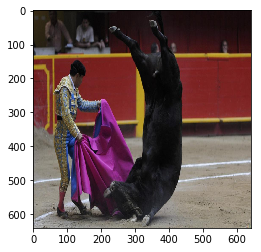

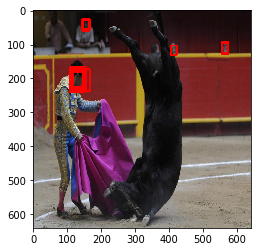

In [234]:
plt.imshow(image_resized[:,:,::-1])
show_anchor(image_resized, final)